# 1. Data Portal Preprocessing

In [2]:
try(library(tidyverse), silent=TRUE)
library(lubridate)
library(glue)
library(data.table)
library(tidyfast)
library("magrittr")
setwd("/")
path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/1_decoded"
data_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS/data"

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'glue'


The following object is masked from 'package:dplyr':

    collapse



Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose



Attaching package: 'magrittr'


The following object i

In [3]:
list.files(path = "/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/")

[1] "death.txt"            "death_cause.txt"      "gp_clinical.txt"     
 [4] "gp_registrations.txt" "gp_scripts.txt"       "hesin.txt"           
 [7] "hesin_critical.txt"   "hesin_delivery.txt"   "hesin_diag.txt"      
[10] "hesin_maternity.txt"  "hesin_oper.txt"       "hesin_psych.txt"

## Load Athena Vocabulary

In [4]:
vocab_dir = glue("{data_path}/athena_vocabulary_covid")
concept =fread(glue("{vocab_dir}/CONCEPT.csv"), sep='\t')

Warning message in fread(glue("{vocab_dir}/CONCEPT.csv"), sep = "\t"):
"Found and resolved improper quoting out-of-sample. First healed line 8811: <<2614984	"y set" tubing for peritoneal dialysis	Device	HCPCS	HCPCS	S	A4719	20020101	20991231	>>. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning."


In [5]:
unique(concept$vocabulary_id)

[1] "ABMS"                 "ATC"                  "CDM"                 
 [4] "CMS Place of Service" "Concept Class"        "Condition Status"    
 [7] "Condition Type"       "Cost"                 "Cost Type"           
[10] "Currency"             "Death Type"           "Device Type"         
[13] "Domain"               "Drug Type"            "Episode"             
[16] "Ethnicity"            "Gender"               "HCPCS"               
[19] "HES Specialty"        "ICD10CM"              "ICD9CM"              
[22] "ICD9Proc"             "Korean Revenue Code"  "LOINC"               
[25] "Meas Type"            "Medicare Specialty"   "Metadata"            
[28] "NDC"                  "NUCC"                 "None"                
[31] "Note Type"            "OMOP Extension"       "OPCS4"               
[34] "OSM"                  "Obs Period Type"      "Observation Type"    
[37] "PHDSC"                "Plan"                 "Plan Stop Reason"    
[40] "Procedure Type"       "Race"                 "Read"                
[43] "Relationship"         "Revenue Code"         "RxNorm"              
[46] "RxNorm Extension"     "SNOMED"               "SPL"                 
[49] "Sponsor"              "Type Concept"         "UB04 Point of Origin"
[52] "UB04 Pri Typ of Adm"  "UB04 Pt dis status"   "UB04 Typ bill"       
[55] "UCUM"                 "US Census"            "Visit"               
[58] "Visit Type"           "Vocabulary"           "dm+d"

In [6]:
relationship = fread(glue("{vocab_dir}/RELATIONSHIP.csv"), sep='\t')

In [7]:
vocabulary =  fread(glue("{vocab_dir}/VOCABULARY.csv"), sep='\t')

In [8]:
concept_relationship = fread(glue("{vocab_dir}/CONCEPT_RELATIONSHIP.csv"), sep='\t')

In [9]:
## Diagnoses

## Hospital Episode Statistics

In [14]:
hesin = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/hesin.txt")

In [15]:
hesin_diag = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/hesin_diag.txt")

In [16]:
hesin_critical = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/hesin_critical.txt")

In [17]:
hesin_psych = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/hesin_psych.txt")

In [18]:
hesin_delivery = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/hesin_delivery.txt")
hesin_maternity = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/hesin_maternity.txt")

### Diagnoses - ICD10

In [19]:
## icd9 to icd10 mapping
icd9to10_df = fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/codings/coding1836.tsv")
icd9to10_mapping = split(icd9to10_df$meaning, icd9to10_df$coding)
hesin_diag_icd9 = hesin_diag %>% filter(diag_icd9!="") %>% rowwise() %>% mutate(diag_icd10 = list(icd9to10_mapping[[diag_icd9]])) %>% drop_na(diag_icd10)
hesin_diag = rbind(hesin_diag %>% filter(diag_icd9=="") %>% mutate(origin="hes_icd10"), hesin_diag_icd9  %>% mutate(origin="hes_icd9"))

In [20]:
hes_join = hesin[hesin_diag, on=c("eid", "ins_index")]
hes_join = hes_join[, c("eid", "origin","ins_index", "arr_index", "level", "epistart", "diag_icd10")][order(eid, ins_index, arr_index),]

In [21]:
hes_join_date = hes_join %>% rename(date="epistart") %>% mutate(date = ymd(as.Date(fast_strptime(date, "%d/%m/%Y"))))

In [22]:
hes_diagnoses = hes_join_date %>% drop_na(date) %>% rename(code = "diag_icd10") %>% mutate(instance=ins_index) %>% group_by(eid) %>% mutate(n = arr_index)

In [23]:
hes_diagnoses = hes_diagnoses %>% mutate(meaning=str_sub(code, 1, 3)) %>% select(c(eid, origin, instance, n, level, code, meaning, date))

In [24]:
nrow(hes_diagnoses)
head(hes_diagnoses %>% arrange(desc(date)))

[1] 13502606

eid,origin,instance,n,level,code,meaning,date
<int>,<chr>,<int>,<int>,<int>,<list>,<chr>,<date>
1003884,hes_icd10,52,0,1,E854,E85,2020-09-30
1003884,hes_icd10,52,1,2,N084,N08,2020-09-30
1003884,hes_icd10,52,2,2,E854,E85,2020-09-30
1003884,hes_icd10,52,3,2,K778,K77,2020-09-30
1003884,hes_icd10,52,4,2,E854,E85,2020-09-30
1003884,hes_icd10,52,5,2,G998,G99,2020-09-30


In [26]:
arrow::write_feather(hes_diagnoses, glue("{path}/codes_hes_diagnoses_210120.feather"))

### Procedures - Snomed CT

In [230]:
# just do opcs4 for now..., no good opcs3 mapping available => SnomedCT Mapping probably the most reasonable...

In [231]:
hesin_oper = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/hesin_oper.txt")

In [232]:
hesin_oper[hesin_oper == ""] <- NA

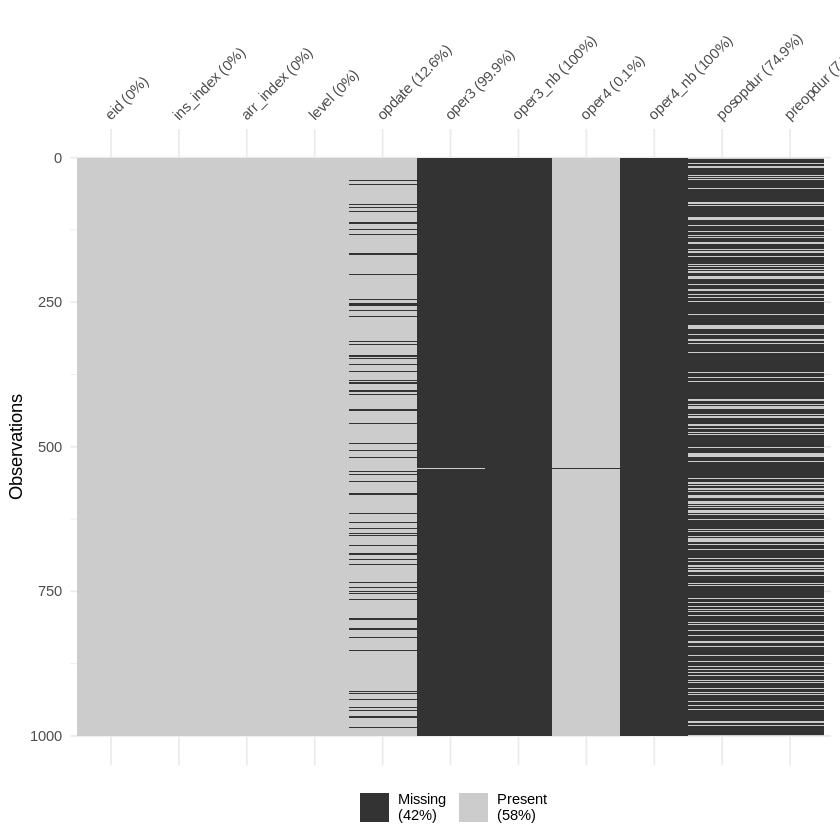

In [233]:
library(visdat)
df = hesin_oper %>% sample_n(1000)
vis_miss(df)

In [234]:
hesin_oper_pre = hesin_oper %>% rename(date="opdate", code="oper4") %>% 
    mutate(date = ymd(as.Date(fast_strptime(date, "%d/%m/%Y"))))  %>%
    mutate(origin="hes_opcs4", instance=ins_index) %>% group_by(eid) %>% mutate(n = arr_index) %>% select(eid, origin, instance, n, level, code, date)

In [235]:
concept_ids_opcs4 = concept %>% filter(vocabulary_id == "OPCS4") %>% mutate(concept_code = str_replace(concept_code, "\\.", ""))
concept_ids_snomed = concept %>% filter(vocabulary_id == "SNOMED" & domain_id=="Procedure") 

# check necessary opcs4 concept ids
concept_ids = concept_ids_opcs4 %>% mutate(concept_id_1 = concept_id)

cr_filtered = concept_relationship %>% filter(concept_id_1 %in% concept_ids_opcs4$concept_id) %>% filter(concept_id_2 %in% concept_ids_snomed$concept_id) %>% arrange(concept_id_1)

In [236]:
mapping_opcs4_snomed = concept_ids_opcs4 %>% 
    left_join(cr_filtered %>% select(concept_id_1, concept_id_2), by=c("concept_id"="concept_id_1")) %>% 
    left_join(concept_ids_snomed %>% select(concept_id, concept_code, concept_name), by=c("concept_id_2"="concept_id")) %>% 
    mutate(code = concept_code.x, meaning=concept_code.y, name=concept_name.y)

In [237]:
hes_procedures = hesin_oper_pre %>% left_join(mapping_opcs4_snomed %>% select(code, meaning, name), by="code") %>% select(eid, origin, instance, n, level, date, code, meaning, name)
nrow(hesin_procedures)
head(hesin_procedures)

[1] 7624501

eid,origin,instance,n,level,date,code,meaning,name
<int>,<chr>,<int>,<int>,<int>,<date>,<chr>,<chr>,<chr>
1000018,hes_opcs4,5,2,2,2018-08-29,Z942,387713003,Surgical procedure
1000018,hes_opcs4,5,1,2,2018-08-29,Z501,NA,NA
1000018,hes_opcs4,4,0,1,2016-11-08,Q108,11401008,Dilation and curettage of uterus
1000018,hes_opcs4,0,0,1,2005-06-02,V093,178397008,Reduction of fracture of zygomatic bone
1000018,hes_opcs4,2,0,1,NA,X998,NA,NA
1000018,hes_opcs4,0,1,2,2005-06-02,Z942,387713003,Surgical procedure


In [238]:
arrow::write_feather(hes_procedures, glue("{path}/codes_hes_procedures_210119.feather"))

## Mortality Records - ICD10

In [239]:
death = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/death.txt")
death_cause = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/death_cause.txt")

In [240]:
death_join = death[death_cause, on=c("eid", "ins_index")]
death_join = death_join[, c("eid", "ins_index", "arr_index", "level", "date_of_death", "cause_icd10")][order(eid, ins_index, arr_index),]

In [241]:
death_join_date = death_join %>% rename(date="date_of_death") %>% rename(code = "cause_icd10") %>% mutate(date = ymd(as.Date(fast_strptime(date, "%d/%m/%Y"))))

In [242]:
codes_death = death_join_date  %>% mutate(instance=0) %>% mutate(origin="death_records") %>% group_by(eid) %>% mutate(n=row_number())
codes_death = codes_death %>% mutate(meaning=str_sub(code, 1, 3)) %>% select(c(eid, origin, instance, n, level, code, meaning, date))

In [243]:
head(codes_death %>% arrange(desc(date)))

eid,origin,instance,n,level,code,meaning,date
<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<date>
5285138,death_records,0,1,1,U071,U07,2020-11-01
5285138,death_records,0,2,2,J449,J44,2020-11-01
1206785,death_records,0,1,1,G309,G30,2020-10-29
1611467,death_records,0,1,1,C260,C26,2020-10-29
1611467,death_records,0,2,2,J189,J18,2020-10-29
2449704,death_records,0,1,1,U071,U07,2020-10-29


In [244]:
arrow::write_feather(codes_death, glue("{path}/codes_death_records_210115.feather"))

## GP Records

In [7]:
gp_registrations = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/gp_registrations.txt")

In [8]:
gp_clinical = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/gp_clinical.txt")

In [9]:
gp_clinical[gp_clinical == ""] <- NA

In [10]:
gp_clinical = gp_clinical %>% rename(date="event_dt") %>% mutate(date = ymd(as.Date(fast_strptime(date, "%d/%m/%Y"))))

In [11]:
# clean_dates
# These data are provided in a form which is as close as possible to how they were issued from their source supplier, in order to avoid potential systematic error or bias by attempting to ‘clean’ them by
# removing or altering invalid or erroneous information. However, to protect individuals, alterations have been made to dates in relation to participant date of birth as follows:

# - where clinical event or prescription date precedes participant date of birth it has been altered to 01/01/1901.
# - Where the date matches participant date of birth it has been altered to 02/02/1902.
# - Where the date follows participant date of birth but is in the year of their birth it has been altered to 03/03/1903.
# - Where the date was in the future this has been changed to 07/07/2037 as these are likely to have been entered as a place-holder or other system default.

In [12]:
gp_clinical = gp_clinical %>% filter(date!="2037-07-07")

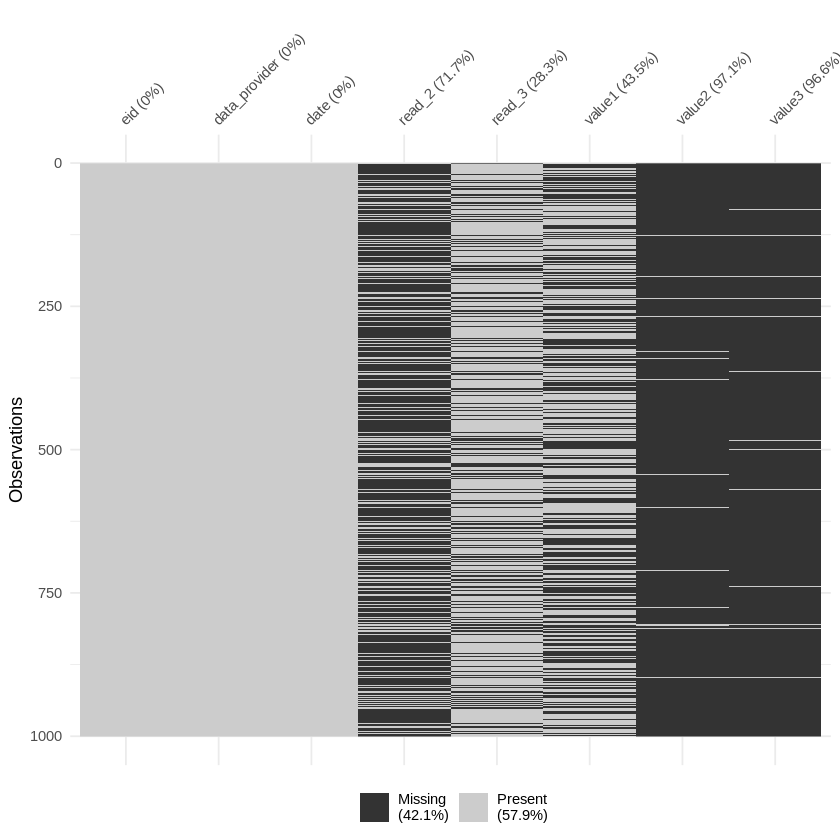

In [190]:
library(visdat)
df = gp_clinical %>% sample_n(1000)
vis_miss(df)

### Diagnoses - ICD10

In [ ]:
readv2_icd10 = head(fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/read_v2_icd10.csv"), -3) %>% rename(read_2="read_code", code ="icd10_code") %>% select(read_2, code)
readv3_icd10 = head(fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/read_ctv3_icd10.csv"), -3)%>% rename(read_3="read_code", code="icd10_code") %>% select(read_3, code)

In [210]:
gp_diagnoses_pre = gp_clinical %>% filter(read_2 %in% readv2_icd10$read_2 | read_3 %in% readv3_icd10$read_3)
gp_diagnoses_readv2 = gp_diagnoses_pre %>% filter(!is.na(read_2)) %>% left_join(readv2_icd10, on="read_2") %>% drop_na(code) %>% mutate(origin="gp_read2") %>% select(eid, origin, code, date)
gp_diagnoses_readv3 = gp_diagnoses_pre %>% filter(!is.na(read_3)) %>% left_join(readv3_icd10, on="read_3") %>% drop_na(code) %>% mutate(origin="gp_read3") %>% select(eid, origin, code, date)
gp_diagnoses_raw = rbind(gp_diagnoses_readv2, gp_diagnoses_readv3)

Joining, by = "read_2"

Joining, by = "read_3"



In [273]:
gp_diagnoses = gp_diagnoses_raw %>% mutate(instance=0, level=NA) %>% distinct() %>% group_by(eid) %>% mutate(n = row_number()) %>% mutate(meaning=str_sub(code, 1, 3)) %>% select(c(eid, origin, instance, n, level, code, meaning, date))
nrow(gp_diagnoses)
head(gp_diagnoses %>% arrange(desc(date)))

[1] 17781180

eid,origin,instance,n,level,code,meaning,date
<int>,<chr>,<dbl>,<int>,<lgl>,<chr>,<chr>,<date>
3375683,gp_read3,0,5,NA,Z016,Z01,2019-01-01
5397213,gp_read3,0,42,NA,Z016,Z01,2019-01-01
4141959,gp_read2,0,54,NA,L309,L30,2017-09-29
5812168,gp_read2,0,24,NA,H609,H60,2017-09-28
1246037,gp_read2,0,26,NA,B379,B37,2017-09-22
2850667,gp_read2,0,12,NA,L988,L98,2017-09-22


In [212]:
arrow::write_feather(gp_diagnoses, glue("{path}/codes_gp_diagnoses_210119.feather"))

### Procedures - Snomed CT

In [ ]:
readv2_opcs4 = head(fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/read_v2_opcs4.csv"), -3) %>% rename(read_2="read_code", code ="opcs_4.2_code") %>% select(read_2, code)
readv3_opcs4 = head(fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/read_ctv3_opcs4.csv"), -3)%>% rename(read_3="read_code", code="opcs4_code") %>% select(read_3, code)

In [214]:
gp_procedures_pre = gp_clinical %>% filter(read_2 %in% readv2_opcs4$read_2 | read_3 %in% readv3_opcs4$read_3)

In [215]:
gp_procedures_readv2 = gp_procedures_pre %>% filter(!is.na(read_2)) %>% left_join(readv2_opcs4, on="read_2") %>% drop_na(code) %>% mutate(origin="gp_read2") %>% select(eid, origin, code, date)
gp_procedures_readv3 = gp_procedures_pre %>% filter(!is.na(read_3)) %>% left_join(readv3_opcs4, on="read_3") %>% drop_na(code) %>% mutate(origin="gp_read3") %>% select(eid, origin, code, date)

Joining, by = "read_2"

Joining, by = "read_3"



In [216]:
gp_procedures_raw = rbind(gp_procedures_readv2, gp_procedures_readv3) %>% mutate(instance=0, level=NA) %>% distinct() %>% group_by(eid) %>% mutate(n = row_number()) 

In [217]:
# opcs4 to snomed mapping

concept_ids_opcs4 = concept %>% filter(vocabulary_id == "OPCS4") %>% mutate(concept_code = str_replace(concept_code, "\\.", ""))
concept_ids_snomed = concept %>% filter(vocabulary_id == "SNOMED" & domain_id=="Procedure") 

# check necessary opcs4 concept ids
concept_ids = concept_ids_opcs4 %>% mutate(concept_id_1 = concept_id)
cr_filtered = concept_relationship %>% filter(concept_id_1 %in% concept_ids_opcs4$concept_id) %>% filter(concept_id_2 %in% concept_ids_snomed$concept_id) %>% arrange(concept_id_1)

mapping_opcs4_snomed = concept_ids_opcs4 %>% 
    left_join(cr_filtered %>% select(concept_id_1, concept_id_2), by=c("concept_id"="concept_id_1")) %>% 
    left_join(concept_ids_snomed %>% select(concept_id, concept_code, concept_name), by=c("concept_id_2"="concept_id")) %>% 
    mutate(code = concept_code.x, meaning=concept_code.y, name=concept_name.y)

In [272]:
gp_procedures = gp_procedures_raw %>% left_join(mapping_opcs4_snomed %>% select(code, meaning, name), by="code") %>% select(eid, origin, instance, n, level, date, code, meaning, name) %>% arrange(eid, date)
nrow(gp_procedures)
head(gp_procedures %>% arrange(desc(date)))

[1] 5689793

eid,origin,instance,n,level,date,code,meaning,name
<int>,<chr>,<dbl>,<int>,<lgl>,<date>,<chr>,<chr>,<chr>
1124200,gp_read2,0,35,NA,2017-09-20,D071,172630005,Syringing ear to remove wax
1369937,gp_read2,0,65,NA,2017-09-20,X36,82078001,Collection of blood specimen for laboratory
1444398,gp_read2,0,6,NA,2017-09-20,U333,448489007,Removal of ambulatory blood pressure monitor
1494963,gp_read2,0,12,NA,2017-09-20,X378,76601001,Intramuscular injection
1612512,gp_read2,0,11,NA,2017-09-20,X378,76601001,Intramuscular injection
1630054,gp_read2,0,52,NA,2017-09-20,X37,76601001,Intramuscular injection


In [222]:
arrow::write_feather(gp_procedures, glue("{path}/codes_gp_procedures_210119.feather"))

### Measurements - Snomed CT

In [257]:
readv2_readv3 = head(fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/read_v2_read_ctv3.csv"), -3) %>% rename(read_2="READV2_CODE", code ="READV3_CODE", name ="TERMV3_DESC") %>% select(read_2, code)

In [250]:
gp_meas = gp_clinical %>% filter(!is.na(value1)) %>% distinct()

In [ ]:
gp_meas_readv2 = gp_meas %>% filter(!is.na(read_2)) %>% left_join(readv2_readv3, by="read_2")
gp_meas_readv2 

In [ ]:
gp_meas_readv3 = gp_meas %>% filter(!is.na(read_3)) %>% mutate(code=read_3)
gp_meas_readv3 

In [ ]:
gp_meas_all = rbind(gp_meas_readv2, gp_meas_readv3) %>% distinct() %>% group_by(eid) 

In [296]:
readv3_lkp = head(fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/read_ctv3_lkp.csv"), -3)%>% rename(code="read_code", name ="term_description") %>% select(code, name)
readv3_sct = fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/CTV3SCTMAP.csv")%>% rename(SCUI="V1", STUI="V2", TCUI="V3", TTUI="V4")%>% rename(code="SCUI", meaning="TCUI") %>% select(code, meaning)
#readct_sct = fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/RCTSCTMAP.csv")%>% rename(SCUI="V1", STUI="V2", TCUI="V3", TTUI="V4")#%>% rename(code="read_code", name ="term_description") %>% select(code, name)#

In [266]:
gp_meas = gp_meas_all %>% left_join(readv3_lkp, by="code")

In [302]:
concept_ids_snomed = concept %>% filter(vocabulary_id == "SNOMED") %>% rename(name="concept_name", meaning="concept_code") %>% select(meaning, name)

In [309]:
gp_meas_uncleaned = gp_meas_all %>% left_join(readv3_sct, by="code") %>% left_join(concept_ids_snomed, by="meaning") %>% distinct()

In [ ]:
gp_meas_cleaned_1 = gp_meas_uncleaned %>% select(eid, date, code, value1, value2, value3, meaning, name) %>% distinct() %>% filter(value1!=0)

In [ ]:
gp_meas_cleaned_2 = gp_meas_cleaned_1 %>% ungroup() %>% filter(!is.na(meaning))

In [376]:
double_df = gp_meas_cleaned_2 %>% filter(!is.na(as.numeric(value1)) & !is.na(as.numeric(value2))) 

Warning message in mask$eval_all_filter(dots, env_filter):
"NAs introduced by coercion"
Warning message in mask$eval_all_filter(dots, env_filter):
"NAs introduced by coercion"


In [410]:
# clean blood pressure and map to systolic and diastolic
bp_double_mapped = double_df %>% filter(name %in% c('O/E - blood pressure reading', 'O/E - BP reading normal', 'O/E - BP reading raised',
                'O/E - BP borderline raised', 'O/E - Systolic BP reading', 'O/E - Diastolic BP reading', 'Sitting blood pressure', "Average home systolic blood pressure",
                'Standing blood pressure','24 hr blood pressure monitoring')) %>% 
     #filter(name %in% c('O/E - Systolic BP reading', 'O/E - Diastolic BP reading', "Average home systolic blood pressure")) %>%
    filter(as.numeric(value1)>0) %>% 
    mutate(value_high = pmax(as.numeric(value1), as.numeric(value2)), value_low = pmin(as.numeric(value1), as.numeric(value2))) %>% 
    filter(value_high>40 & value_low>20 & value_high<400 & value_low<300)  %>% rename("163030003" = "value_high", "163031004" = "value_low") %>% 
    select(-c(meaning, name)) %>% pivot_longer(c("163030003", "163031004"), names_to="meaning", values_to="value") %>% left_join(concept_ids_snomed, by="meaning") %>% distinct() %>% arrange(eid) %>%
    select(eid, date, code, value1, value2, value3, meaning, name, value)

In [422]:
gp_meas_single = gp_meas_cleaned_2 %>% filter(is.na(as.numeric(value1)) | is.na(as.numeric(value2))) %>%
    mutate(value=case_when(!is.na(as.numeric(value1)) ~ as.numeric(value1), is.na(as.numeric(value1)) ~ as.numeric(value2))) %>% filter(!is.na(value))

Warning message in mask$eval_all_filter(dots, env_filter):
"NAs introduced by coercion"
Warning message in mask$eval_all_filter(dots, env_filter):
"NAs introduced by coercion"
Warning message:
"Problem with `mutate()` input `value`.
i NAs introduced by coercion
i Input `value` is `case_when(...)`."
Warning message in eval_tidy(pair$lhs, env = default_env):
"NAs introduced by coercion"
Warning message:
"Problem with `mutate()` input `value`.
i NAs introduced by coercion
i Input `value` is `case_when(...)`."
Warning message in eval_tidy(pair$rhs, env = default_env):
"NAs introduced by coercion"
Warning message:
"Problem with `mutate()` input `value`.
i NAs introduced by coercion
i Input `value` is `case_when(...)`."
Warning message in eval_tidy(pair$lhs, env = default_env):
"NAs introduced by coercion"
Warning message:
"Problem with `mutate()` input `value`.
i NAs introduced by coercion
i Input `value` is `case_when(...)`."
Warning message in eval_tidy(pair$rhs, env = default_env):
"NAs 

In [ ]:
gp_meas_cleaned_3 = rbind(gp_meas_single, bp_double_mapped) %>% distinct() %>% arrange(eid, date)
gp_meas_cleaned_3

In [428]:
arrow::write_feather(gp_meas_cleaned_3, glue("{path}/codes_gp_measurements_210120.feather"))

### Prescriptions - RXNorm

In [6]:
gp_scripts = fread("/data/project/uk_bb/cvd/data/ukb_downloads/updated_showcase_43098/ukb_data/records/gp_scripts.txt")

In [7]:
gp_scripts[gp_scripts == ""] <- NA

In [8]:
gp_scripts = gp_scripts %>% mutate(date = ymd(as.Date(fast_strptime(issue_date, "%d/%m/%Y"))))

In [12]:
gp_scripts_names_available = gp_scripts %>% filter(!is.na(drug_name))

In [75]:
gp_scripts_read_available = gp_scripts %>% filter(is.na(drug_name))

In [20]:
drug_names = (gp_scripts_names_available %>% count(drug_name, sort=TRUE))$drug_name

In [21]:
library(jsonlite)
write_json(drug_names, glue("{path}/drug_names.json"))

In [51]:
name_umls_link = arrow::read_feather(glue("{path}/drug_names_umls_linked.feather"))

In [53]:
drugs_rxnorm = arrow::read_feather(glue("{path}/drug_names_umls_linked_rxnorm.feather"))

In [67]:
rx_mapping = concept %>% filter(vocabulary_id %in% c('RxNorm','RxNorm Extension')) %>% select(concept_code, concept_name) %>% rename(rx_code ="concept_code", name="concept_name")

In [69]:
rx_norm_mapping_table = drugs_rxnorm %>% select(drug_name, rx_code) %>% filter(rx_code != "") %>% distinct() %>% left_join(rx_mapping, on="rx_code")

Joining, by = "rx_code"



In [80]:
gp_scripts_rxnorm = gp_scripts_names_available %>% left_join(rx_norm_mapping_table, on="drug_name") %>% select(eid, date, drug_name, rx_code, name) %>% distinct()
gp_scripts_rxnorm 

Joining, by = "drug_name"



eid,date,drug_name,rx_code,name
<int>,<date>,<chr>,<chr>,<chr>
1000018,1996-11-30,Doxycycline 100mg capsules,3640,doxycycline
1000018,1997-09-12,Propranolol 40mg tablets,8787,propranolol
1000018,1997-10-10,Propranolol 40mg tablets,8787,propranolol
1000018,1997-10-10,Noriday 350microgram tablets (Pfizer Ltd),NA,NA
1000018,1998-01-19,Propranolol 40mg tablets,8787,propranolol
1000018,1998-01-19,Propranolol 80mg tablets,8787,propranolol
1000018,1998-01-19,Gamolenic acid 40mg capsules,25605,gamma-linolenic acid
1000018,1998-03-13,Propranolol 80mg tablets,8787,propranolol
1000018,1998-03-25,Amoxicillin 250mg capsules,723,amoxicillin


In [1]:
R.Version()

$platform
[1] "x86_64-conda-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] ""

$major
[1] "4"

$minor
[1] "0.3"

$year
[1] "2020"

$month
[1] "10"

$day
[1] "10"

$`svn rev`
[1] "79318"

$language
[1] "R"

$version.string
[1] "R version 4.0.3 (2020-10-10)"

$nickname
[1] "Bunny-Wunnies Freak Out"

In [87]:
arrow::write_feather(gp_scripts_rxnorm, glue("{path}/codes_gp_prescription_scispacy_210121.feather"))

In [ ]:
### OLD NOT WORKING TRASH

In [83]:
readv2_readv3 = head(fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/read_v2_read_ctv3.csv"), -3) %>% rename(read_2="READV2_CODE", code ="READV3_CODE", name ="TERMV3_DESC") %>% select(read_2, code)

In [84]:
gp_scripts_read3 = gp_scripts_read_available %>% left_join(readv2_readv3, by="read_2")

In [86]:
gp_scripts_read3 %>% drop_na(code)

eid,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,date,code
<int>,<int>,<chr>,<chr>,<chr>,<int64>,<chr>,<chr>,<date>,<chr>


In [71]:
bnf_snomed_mapping = fread("/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/gp_codings/bnf_snomed_mapping.csv") %>%
    rename(bnf_code="BNF Code", sct_code ="SNOMED Code") %>% 
    filter(`VMP / VMPP/ AMP / AMPP`=="VMP") %>% 
    filter(bnf_code != "") %>% mutate(bnf_map = str_sub(bnf_code, 1, 7))

In [72]:
gp_test = gp_scripts %>% sample_n(1000) %>% filter(bnf_code != "") %>% mutate(bnf_code =str_replace_all(bnf_code, "\\.", ""))

In [100]:
gp_scripts_pre = gp_test %>% mutate(bnf_map = str_sub(bnf_code, 1, 7)) %>% left_join(bnf_snomed_mapping %>% select(bnf_map, sct_code), by="bnf_map") %>% distinct() %>% drop_na(sct_code)
gp_scripts_pre 

eid,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,date,bnf_map,sct_code
<int>,<int>,<chr>,<chr>,<chr>,<int64>,<chr>,<chr>,<date>,<chr>,<int64>
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,374294006
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,374295007
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,374296008
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,325315001
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,325316000
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,8584011000001100
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,8584111000001104
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,8584211000001105
5157903,3,25/05/2010,NA,0602010000,NA,Levothyroxine sodium 100microgram tablets,56 tablet(s) - 100 micrograms,2010-05-25,0602010,8584411000001109


In [180]:
concept

concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
45756805,Pediatric Cardiology,Provider,ABMS,Physician Specialty,S,OMOP4821938,19700101,20991231,
45756804,Pediatric Anesthesiology,Provider,ABMS,Physician Specialty,S,OMOP4821939,19700101,20991231,
45756803,Pathology-Anatomic/Pathology-Clinical,Provider,ABMS,Physician Specialty,S,OMOP4821940,19700101,20991231,
45756802,Pathology - Pediatric,Provider,ABMS,Physician Specialty,S,OMOP4821941,19700101,20991231,
45756801,Pathology - Molecular Genetic,Provider,ABMS,Physician Specialty,S,OMOP4821942,19700101,20991231,
45756800,Microbiology,Provider,ABMS,Physician Specialty,S,OMOP4821943,19700101,20991231,
45756799,Pathology - Hematology,Provider,ABMS,Physician Specialty,S,OMOP4821944,19700101,20991231,
45756798,Pathology - Forensic,Provider,ABMS,Physician Specialty,S,OMOP4821945,19700101,20991231,
45756797,Pathology - Clinical,Provider,ABMS,Physician Specialty,S,OMOP4821946,19700101,20991231,


In [185]:
# opcs4 to snomed mapping
bnf_map = bnf_snomed_mapping %>% select(bnf_map, sct_code) %>% mutate(sct_code = as.character(sct_code)) %>% distinct()
concept_ids_snomed_input = concept %>% filter(vocabulary_id == "SNOMED" & concept_code %in% unique(bnf_map$sct_code)) %>% mutate(concept_code = str_replace(concept_code, "\\.", ""))
concept_ids_snomed_substance = concept %>% filter(vocabulary_id == "SNOMED" & domain_id =="Drug", concept_class_id=="Substance") %>% mutate(concept_code = str_replace(concept_code, "\\.", ""))
#concept_ids_snomed_ingred = concept %>% filter(vocabulary_id == "SNOMED" & domain_id=="Procedure") 

In [191]:
# check necessary opcs4 concept ids
#concept_ids = unique(concept_ids_snomed_input %>% mutate(concept_id_1 = concept_id))$concept_id_1
cr_filtered = concept_relationship %>% 
    filter(concept_id_1 %in% concept_ids_snomed_input$concept_id) %>% 
    filter(concept_id_2 %in% concept_ids_snomed_substance$concept_id) %>% 
    filter(relationship_id %in% c("Has active ing")) %>%
    arrange(concept_id_1) 

In [196]:
mapping_snomed_substance = concept_ids_snomed_input %>% 
    left_join(cr_filtered %>% select(concept_id_1, concept_id_2), by=c("concept_id"="concept_id_1")) %>% 
    left_join(concept_ids_snomed_substance %>% select(concept_id, concept_code, concept_name), by=c("concept_id_2"="concept_id")) %>% 
    mutate(code = concept_code.x, meaning=concept_code.y, name=concept_name.y) %>% select(code, meaning, name)

In [201]:
gp_scripts_pre %>% mutate(sct_code=as.character(sct_code)) %>% left_join(mapping_snomed_substance, by=c("sct_code"="code")) %>% select(eid, bnf_code, drug_name, date, meaning, name) %>% distinct()

eid,bnf_code,drug_name,date,meaning,name
<int>,<chr>,<chr>,<date>,<chr>,<chr>
5157903,0602010000,Levothyroxine sodium 100microgram tablets,2010-05-25,710809001,Levothyroxine
5157903,0602010000,Levothyroxine sodium 100microgram tablets,2010-05-25,61275002,Liothyronine
5157903,0602010000,Levothyroxine sodium 100microgram tablets,2010-05-25,NA,NA
3039302,0310000000,Pseudoephedrine hydrochloride 60mg tablets,2004-12-03,372900003,Pseudoephedrine
3039302,0310000000,Pseudoephedrine hydrochloride 60mg tablets,2004-12-03,NA,NA
3039302,0310000000,Pseudoephedrine hydrochloride 60mg tablets,2004-12-03,387517004,Paracetamol
3039302,0310000000,Pseudoephedrine hydrochloride 60mg tablets,2004-12-03,372771005,Phenylephrine
3039302,0310000000,Pseudoephedrine hydrochloride 60mg tablets,2004-12-03,387464001,Phenylpropanolamine
3039302,0310000000,Pseudoephedrine hydrochloride 60mg tablets,2004-12-03,387207008,Ibuprofen


In [197]:
mapping_snomed_substance 

code,meaning,name
<chr>,<chr>,<chr>
10050811000001105,NA,NA
10051011000001108,NA,NA
10051911000001107,NA,NA
10052111000001104,385544005,Pegfilgrastim
10063711000001101,391852006,Bismuth subnitrate
10063811000001109,126189002,Desmopressin
10063911000001104,126189002,Desmopressin
10064111000001100,NA,NA
10064211000001106,NA,NA


In [30]:
gp_scripts_read2 = gp_scripts %>% filter(!is.na(read_2)) %>% arrange(eid)
gp_scripts_read3 = gp_scripts_read2 %>% left_join(readv2_readv3, by="read_2")
gp_scripts_read3

eid,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,date,code
<int>,<int>,<chr>,<chr>,<chr>,<int64>,<chr>,<chr>,<date>,<chr>
1000020,2,06/10/2016,dher.,04065400,NA,Prochlorperazine 5mg tablets,28.000,2016-10-06,NA
1000360,4,17/09/1993,a23y.,NA,NA,NA,NA,1993-09-17,NA
1000360,4,15/07/1996,j28B.,NA,NA,NA,NA,1996-07-15,NA
1000360,4,12/06/1997,j28B.,NA,NA,NA,NA,1997-06-12,NA
1000360,4,26/06/1998,c8o1.,NA,NA,NA,NA,1998-06-26,NA
1000360,4,26/06/1998,l81z.,NA,NA,NA,NA,1998-06-26,NA
1000360,4,01/09/1998,l81z.,NA,NA,NA,NA,1998-09-01,NA
1000360,4,19/11/1998,l81z.,NA,NA,NA,NA,1998-11-19,NA
1000360,4,19/05/1999,aj1t.,NA,NA,NA,NA,1999-05-19,NA


In [27]:
gp_scripts %>% filter(!is.na(read_2) | !is.na(dmd_code)) %>% arrange(eid)

eid,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity,date
<int>,<int>,<chr>,<chr>,<chr>,<int64>,<chr>,<chr>,<date>
1000018,3,30/11/1996,NA,13.06.02.01.00,NA,Doxycycline 100mg capsules,8 capsule(s) - 100 mg,1996-11-30
1000018,3,12/09/1997,NA,02.03.02.02.00,NA,Propranolol 40mg tablets,56 tablet(s) - 40 mg,1997-09-12
1000018,3,10/10/1997,NA,02.03.02.02.00,NA,Propranolol 40mg tablets,168 tablet(s) - 40 mg,1997-10-10
1000018,3,10/10/1997,NA,07.03.02.01.00,NA,Noriday 350microgram tablets (Pfizer Ltd),168 tablet(s) - 350 micrograms,1997-10-10
1000018,3,19/01/1998,NA,02.03.02.02.00,NA,Propranolol 40mg tablets,168 tablet(s) - 40 mg,1998-01-19
1000018,3,19/01/1998,NA,02.03.02.02.00,NA,Propranolol 80mg tablets,112 tablet(s) - 80 mg,1998-01-19
1000018,3,19/01/1998,NA,06.07.02.00.00,NA,Gamolenic acid 40mg capsules,336 capsule(s) - 40 mg,1998-01-19
1000018,3,13/03/1998,NA,02.03.02.02.00,NA,Propranolol 80mg tablets,112 tablet(s) - 80 mg,1998-03-13
1000018,3,25/03/1998,NA,05.01.01.03.00,NA,Amoxicillin 250mg capsules,15 capsule(s) - 250 mg,1998-03-25


In [137]:
gp_scripts %>% filter(!is.na(dmd_code))

eid,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity
<int>,<int>,<chr>,<chr>,<chr>,<int64>,<chr>,<chr>
1000614,1,22/04/2004,djiG.00,,322637009,Tramadol modified release capsule 100mg,30.000
1000614,1,23/09/2004,e311.,,323509004,Amoxicillin capsules 250mg,21.000
1000614,1,28/10/2005,c13J.00,,320139002,Salbutamol cfc free inhaler 100micrograms/inhalation,2.000
1000614,1,28/10/2005,e311.,,323509004,Amoxicillin capsules 250mg,15.000
1000614,1,28/10/2005,k32w.00,,330295009,Chloramphenicol ophthalmic ointment 1%,4.000
1000614,1,11/11/2005,c61t.00,,320531008,Beclometasone 250micrograms/dose inhaler,2.000
1000614,1,28/11/2005,fe6j.00,,325444003,Prednisolone sodium phosphate soluble tablet 5mg,30.000
1000614,1,08/12/2005,ecc2.00,,324431001,Trimethoprim tablets 200mg,14.000
1000614,1,27/10/2006,e311.,,323509004,Amoxicillin capsules 250mg,21.000


In [19]:
bnf_map = fread("data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/bnf_codings.csv")

In [40]:
bnf_map_clean = bnf_map %>% mutate(code=str_sub(BNF_Presentation_Code, 1, 6)) %>% 
    distinct() %>% 
    mutate(label=case_when(str_detect(BNF_Paragraph, "DUMMY")~BNF_Section, TRUE ~ BNF_Paragraph)) %>%
    select(code, label, BNF_Subparagraph, BNF_Paragraph, BNF_Section, BNF_Chapter) %>% distinct()

In [50]:
test = gp_scripts %>% mutate(code=str_replace_all(bnf_code, ".", ""))#%>% mutate(code=str_sub(str_remove_all(bnf_code, "."), 1, 6))

In [53]:
str(test)

Classes 'data.table' and 'data.frame':	47242673 obs. of  9 variables:
 $ eid          : int  1000018 1000018 1000018 1000018 1000018 1000018 1000018 1000018 1000018 1000018 ...
 $ data_provider: int  3 3 3 3 3 3 3 3 3 3 ...
 $ issue_date   : chr  "30/11/1996" "12/09/1997" "10/10/1997" "10/10/1997" ...
 $ read_2       : chr  "" "" "" "" ...
 $ bnf_code     : chr  "13.06.02.01.00" "02.03.02.02.00" "02.03.02.02.00" "07.03.02.01.00" ...
 $ dmd_code     :integer64 NA NA NA NA NA NA NA NA ... 
 $ drug_name    : chr  "Doxycycline 100mg capsules" "Propranolol 40mg tablets" "Propranolol 40mg tablets" "Noriday 350microgram tablets (Pfizer Ltd)" ...
 $ quantity     : chr  "8 capsule(s) - 100 mg" "56 tablet(s) - 40 mg" "168 tablet(s) - 40 mg" "168 tablet(s) - 350 micrograms" ...
 $ code         : chr  "" "" "" "" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [14]:
library(visdat)
library(naniar)

In [10]:
library(Hmisc)
str(gp_scripts)

Classes 'data.table' and 'data.frame':	47242673 obs. of  8 variables:
 $ eid          : int  1000018 1000018 1000018 1000018 1000018 1000018 1000018 1000018 1000018 1000018 ...
 $ data_provider: int  3 3 3 3 3 3 3 3 3 3 ...
 $ issue_date   : chr  "30/11/1996" "12/09/1997" "10/10/1997" "10/10/1997" ...
 $ read_2       : chr  "" "" "" "" ...
 $ bnf_code     : chr  "13.06.02.01.00" "02.03.02.02.00" "02.03.02.02.00" "07.03.02.01.00" ...
 $ dmd_code     :integer64 NA NA NA NA NA NA NA NA ... 
 $ drug_name    : chr  "Doxycycline 100mg capsules" "Propranolol 40mg tablets" "Propranolol 40mg tablets" "Noriday 350microgram tablets (Pfizer Ltd)" ...
 $ quantity     : chr  "8 capsule(s) - 100 mg" "56 tablet(s) - 40 mg" "168 tablet(s) - 40 mg" "168 tablet(s) - 350 micrograms" ...
 - attr(*, ".internal.selfref")=<externalptr> 


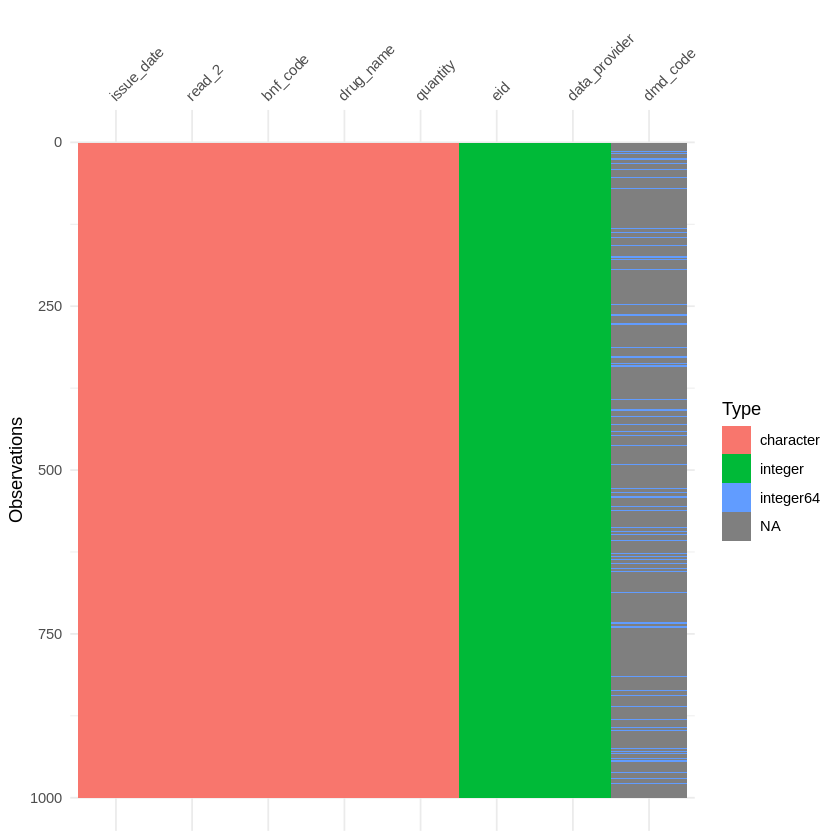

In [15]:
library(visdat)
df = gp_scripts %>% sample_n(1000)
vis_dat(df)

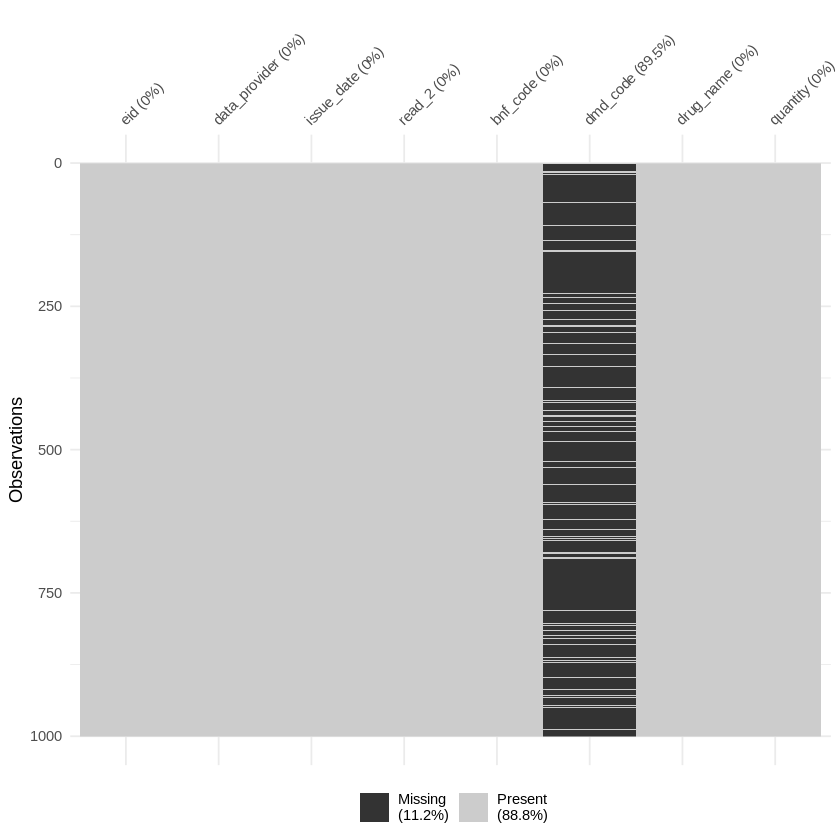

In [16]:
library(naniar)
df = gp_scripts %>% sample_n(1000)
vis_miss(df)

In [ ]:
data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb/mapping/bnf_codings.csv

In [ ]:
nrow(gp_registrations)
head(gp_registrations)

In [ ]:
nrow(gp_clinical)
head(gp_clinical)

In [ ]:
str(gp_clinical)